In [100]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import punkt
from nltk.corpus.reader import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
path_svm =  'Models/best_lrc.pickle'
with open(path_svm, 'rb') as data:
    svc_model = pickle.load(data)

path_tfidf = "Pickles/tfidf.pickle"
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)

path_df = "Pickles/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
path_df = "Pickles/DFNONE.pickle"
with open(path_df, 'rb') as data:
    dfToTag = pickle.load(data)
    
path_category_names = "Pickles/category_names.pickle"
with open(path_category_names, 'rb') as data:
    category_names = pickle.load(data)
    
path_category_codes = "Pickles/category_codes.pickle"
with open(path_category_codes, 'rb') as data:
    category_codes = pickle.load(data)

In [102]:
punctuation_signs = list("?:!.,;")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Clean'] = df['Content'].str.replace("\r", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace("\n", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace("    ", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace('"', '')
    df['Content_Clean'] = df['Content_Clean'].str.lower()
    df['Content_Clean'] = df['Content_Clean']
    for punct_sign in punctuation_signs:
        df['Content_Clean'] = df['Content_Clean'].str.replace(punct_sign, '')
    df['Content_Clean'] = df['Content_Clean'].str.replace("'s", "")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Clean']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Clean'] = lemmatized_text_list
    df['Content_Clean'] = df['Content_Clean']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Clean'] = df['Content_Clean'].str.replace(regex_stopword, '')
    df = df['Content_Clean']
    #df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
    #df = df.rename(columns={"A": "a", "B": "c"})
    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

In [103]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [104]:
def predict_from_text(text,debug):
    
    # Predict using the input model
    prediction_svc = svc_model.predict(create_features_from_text(text))[0]
    prediction_svc_proba = svc_model.predict_proba(create_features_from_text(text))[0]
    
    # Return result
    category_svc = get_category_name(prediction_svc)
    scoring = prediction_svc_proba.max()*100
    if debug:
        print("The predicted category using the model is %s." %(category_svc) )
        print("The conditional probability is: %a" %(scoring))
    
    return prediction_svc,scoring,category_svc

In [105]:
predict_from_text("  ndt gauge ",True)

The predicted category using the model is PiezosNDT.
The conditional probability is: 41.305156545204525


(7, 41.305156545204525, 'PiezosNDT')

In [106]:
TODO = dfToTag
TODO["Hypothese"] = TODO["Title"].apply(lambda x: predict_from_text(str(x),False))
TODO[['new_group','confidence','new_category']] = pd.DataFrame(TODO.Hypothese.values.tolist(), index= TODO.index)
TODO.to_excel("todo.xlsx")
TODO

,ItemID,value,_currencyID,ViewItemURLForNaturalSearch,Title,PrimaryCategoryID,Country,Description,group,Hypothese,new_group,confidence,new_category
0,383457623371,1250.0,USD,https://www.ebay.com/itm/PHILIPS-3D9-3V-ULTRAS...,PHILIPS 3D9-3V ULTRASOUND TRANSDUCER PROBE,184515,US,PHILIPS 3D9-3V ULTRASOUND TRANSDUCER PROBE. Co...,None,"(1, 94.48967470109754, Array)",1,94.489675,Array
1,392584673255,399.0,USD,https://www.ebay.com/itm/MCube-CubeScan-Cube-S...,MCube CubeScan Cube Scan BioCon-700 Bladder Sc...,3179,US,MCube CubeScan Cube Scan BioCon-700 Bladder Sc...,None,"(4, 43.02884674576124, HH)",4,43.028847,HH
2,383457629497,115.0,USD,https://www.ebay.com/itm/Acuson-8V5-Ultrasound...,Acuson 8V5 Ultrasound/Transducer Probe ~ with ...,181961,US,Acuson 8V5 Ultrasound/Transducer Probe ~ with ...,None,"(1, 95.43149745973749, Array)",1,95.431497,Array
3,254459167401,1999.0,USD,https://www.ebay.com/itm/Olympus-Sonic-1200S-U...,Olympus Sonic 1200S Ultrasonic Flaw Detector -...,181989,US,Ultrasonic Flaw DetectorStock #191108NIncluded...,None,"(3, 77.9924093717159, NDT)",3,77.992409,NDT
4,223943552530,802.0,USD,https://www.ebay.com/itm/Seimen-7CF2-Ultrasoun...,Seimen 7CF2 Ultrasound Transducer Probe,184515,US,"Cosmatically it is good .,meet and clean.but I...",None,"(1, 80.37177703919454, Array)",1,80.371777,Array
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,274218688389,350.0,USD,https://www.ebay.com/itm/Aloka-SSD-a5-Ultrasou...,Aloka SSD-a5 Ultrasound Probe Board EP451000DG...,184542,US,Home About Us Feedback View all listing...,None,"(8, 52.75812678698076, Boards)",8,52.758127,Boards
1099,172578707455,75.0,USD,https://www.ebay.com/itm/Hitachi-SDEL-1-CU4096...,Hitachi SDEL-1 CU4096 Module For Hitachi EZU-M...,184542,US,"281 South Road, Route 107Kensington, N...",None,"(2, 41.752966902048236, NotUS)",2,41.752967,NotUS
1100,283802108150,1079.1,USD,https://www.ebay.com/itm/Verathon-BladderScan-...,Verathon BladderScan 0570-0347 Ultrasound Prob...,184515,US,Verathon BladderScan Ultrasound Probe. 0570-03...,None,"(1, 53.36492687605452, Array)",1,53.364927,Array
1101,274278073840,740.21,USD,https://www.ebay.com/itm/Aloka-Ultrasound-Boar...,Aloka Ultrasound Board EP525400CC,184542,IL,Aloka Ultrasound Board EP525400CCWe pride ours...,None,"(8, 56.04401667586816, Boards)",8,56.044017,Boards


# Review of the model

In [87]:
new = pd.read_excel("todo.xlsx")
print(new.columns.tolist())
new.head()

['Unnamed: 0', 'ItemID', 'value', '_currencyID', 'ViewItemURLForNaturalSearch', 'Title', 'PrimaryCategoryID', 'Country', 'Description', 'group', 'Hypothese', 'new_group', 'confidence', 'new_category', 'reviewed']


,Unnamed: 0,ItemID,value,_currencyID,ViewItemURLForNaturalSearch,Title,PrimaryCategoryID,Country,Description,group,Hypothese,new_group,confidence,new_category,reviewed
0,234,164118054719,920.00,USD,https://www.ebay.com/itm/Veterinary-Ultrasound...,Veterinary Ultrasound Scanner Machine Livestoc...,184515,US,"Veterinary handheld, palmtop ultrasound scanne...",None,"(4, 99.5757523456277, 'HH')",4,99.575752,HH,HH
1,115,163885928854,719.35,USD,https://www.ebay.com/itm/Portable-Ultrasound-S...,Portable Ultrasound Scanner Veterinary VET Sca...,184542,CN,p:empty+hr{display:none}hr+span.ebay{display:n...,None,"(4, 99.53845324276787, 'HH')",4,99.538453,HH,HH
2,301,264314328478,899.00,USD,https://www.ebay.com/itm/CMS600P2-VET-Portable...,CMS600P2 VET Portable Veterinary Ultrasound Sc...,184515,US,...,None,"(4, 99.49148880771293, 'HH')",4,99.491489,HH,HH
3,315,114145101439,889.00,USD,https://www.ebay.com/itm/Portable-Veterinary-U...,Portable Veterinary Ultrasound scanner noteboo...,184542,US,Click images to enlarg...,None,"(4, 99.45261103439816, 'HH')",4,99.452611,HH,HH
4,3,392720511035,759.00,USD,https://www.ebay.com/itm/Carejoy-Portable-Vete...,Carejoy Portable Veterinary WristScan Machine ...,184515,US,.dc-dock{position:absolute;width:35px;height:2...,None,"(4, 99.41823460142096, 'HH')",4,99.418235,HH,HH


In [88]:
import os
pathimg = "/home/kelu/ultrasound/ebaystrove/images/"
if "reviewed" in new.columns.tolist():
    for row in range(len(new)):
        if new.iloc[row]["group"] == "None":
            pathfrom = pathimg + str(new.iloc[row]["ItemID"])
        else:
            pathfrom = pathimg + new.iloc[row]["group"] + "/" + str(new.iloc[row]["ItemID"])
        pathto = pathimg + new.iloc[row]["reviewed"] + "/"

        try:
            os.rename(pathfrom + ".jpg", pathto+str(new.iloc[row]["ItemID"])+".jpg")
        except:
            p = 0

In [89]:
new["correct"] = "Incorrect"
new.correct.loc[new.new_category == new.reviewed ] = "Correct"
new.head()

/home/kelu/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Unnamed: 0,ItemID,value,_currencyID,ViewItemURLForNaturalSearch,Title,PrimaryCategoryID,Country,Description,group,Hypothese,new_group,confidence,new_category,reviewed,correct
0,234,164118054719,920.00,USD,https://www.ebay.com/itm/Veterinary-Ultrasound...,Veterinary Ultrasound Scanner Machine Livestoc...,184515,US,"Veterinary handheld, palmtop ultrasound scanne...",None,"(4, 99.5757523456277, 'HH')",4,99.575752,HH,HH,Correct
1,115,163885928854,719.35,USD,https://www.ebay.com/itm/Portable-Ultrasound-S...,Portable Ultrasound Scanner Veterinary VET Sca...,184542,CN,p:empty+hr{display:none}hr+span.ebay{display:n...,None,"(4, 99.53845324276787, 'HH')",4,99.538453,HH,HH,Correct
2,301,264314328478,899.00,USD,https://www.ebay.com/itm/CMS600P2-VET-Portable...,CMS600P2 VET Portable Veterinary Ultrasound Sc...,184515,US,...,None,"(4, 99.49148880771293, 'HH')",4,99.491489,HH,HH,Correct
3,315,114145101439,889.00,USD,https://www.ebay.com/itm/Portable-Veterinary-U...,Portable Veterinary Ultrasound scanner noteboo...,184542,US,Click images to enlarg...,None,"(4, 99.45261103439816, 'HH')",4,99.452611,HH,HH,Correct
4,3,392720511035,759.00,USD,https://www.ebay.com/itm/Carejoy-Portable-Vete...,Carejoy Portable Veterinary WristScan Machine ...,184515,US,.dc-dock{position:absolute;width:35px;height:2...,None,"(4, 99.41823460142096, 'HH')",4,99.418235,HH,HH,Correct


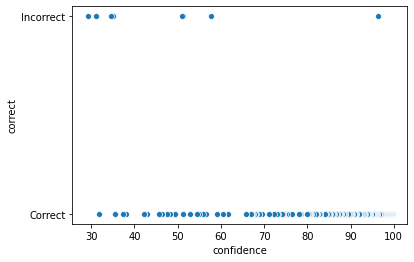

In [90]:
sns.scatterplot(x="confidence", y="correct", data=new)

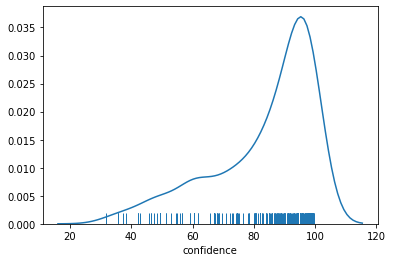

In [91]:
sns.distplot(new[new.correct == "Correct"].confidence, hist=False, rug=True);

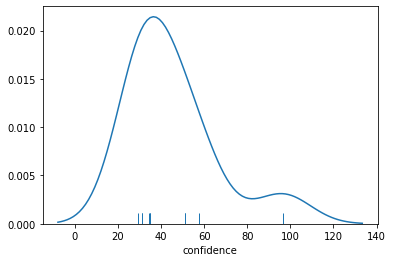

In [92]:
sns.distplot(new[new.correct == "Incorrect"].confidence, hist=False, rug=True);

In [98]:
new.groupby(["correct"]).Title.count()

correct
Correct      310
Incorrect     10
Name: Title, dtype: int64

In [99]:
pd.DataFrame(new.groupby(["reviewed","correct"]).Title.count())

Title
reviewed    correct         
Array       Correct      142
            Incorrect      2
FullMachine Correct        6
            Incorrect      1
HH          Correct       61
MechProbe   Incorrect      3
NDT         Correct        8
NotUS       Correct       88
            Incorrect      3
PiezosNDT   Correct        5
Unsure      Incorrect      1